### Music generator
Network are learned to predict next magnitude and phase of spectrum in a music file.
After that it creates its own sound by passing output to input.

Here we set up plot inlining options and its size:

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython import display

Import modules:

In [2]:
import pynn as nn
import pynnui as nnui
from math import floor, sin, pi
from copy import copy
from scipy.io import wavfile
import numpy as np
from matplotlib import pyplot as plt
import signal

Load `.wav` file:

In [3]:
br, data = wavfile.read('data/canon.wav')
data = np.dot(data, np.array([0.5, 0.5])) # convert stereo to mono
data = np.array(data, dtype=float)/0x7FFF
print(br)

44100


Or generate your own:

In [3]:
br = 44100
data = np.zeros(10*br)

freq = 1000 # Hz
mag = 0.5
phase = 0.0
dt = 1/br
for i in range(len(data)):
    data[i] = mag*sin(phase)
    phase += 2*pi*freq*dt

wavfile.write('in.wav', br, data)

Hyperparameters:

In [4]:
size = 256
shid = 16
seq_len = 16
rate_factor = 1e-1

To learn our network we use [BPTT](https://en.wikipedia.org/wiki/Backpropagation_through_time) with [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) plus [AdaGrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad). Tanh cross entropy loss is used.

In [5]:
def learn(net, state, pos, seq_len):
    loss = 0
    grad = net.newGradient()
    
    if(pos + seq_len*size > len(data)):
        seq_len = floor((len(data) - pos)/size) - 1
    
    state_stack = []
    vouts_stack = []
    
    vins = [data[pos : pos + size]]
    for i in range(seq_len):
        # feedforward
        vouts = np.real(net.transmit(state, vins))
        state_stack.append(copy(state))
        vouts_stack.append(vouts)
        vins = vouts

    error = net.newError()
    
    for i in reversed(range(seq_len)):
        vres = data[pos + (i+1)*size : pos + (i+2)*size]
        vout = vouts_stack.pop()[0]
        tvout = np.tanh(vout)
        verrs = [tvout - vres]
        loss += np.sum(verrs[0]**2)

        # backpropagate
        net.backprop(grad, error, state_stack.pop(), verrs)
        
    return (grad, loss)

Define network structure:

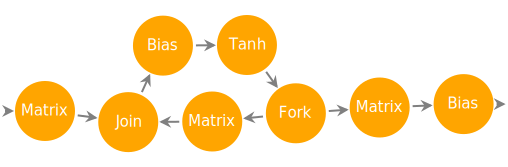

In [6]:
net = nn.Network(1, 1)

opts = {'complex': False}
net.nodes[0] = nn.MatrixProduct(size, shid, **opts) # W_xh
net.nodes[1] = nn.MatrixProduct(shid, shid, **opts) # W_hh
net.nodes[2] = nn.Join(shid, 2, **opts)
net.nodes[3] = nn.Bias(shid, **opts)
net.nodes[4] = nn.Tanh(shid, **opts)
net.nodes[5] = nn.Fork(shid, 2, **opts)
net.nodes[6] = nn.MatrixProduct(shid, size, **opts) # W_hy
net.nodes[7] = nn.Bias(size, **opts)

net.link(nn.Path((-1, 0), ( 0, 0)))
net.link(nn.Path(( 0, 0), ( 2, 0)))
net.link(nn.Path(( 1, 0), ( 2, 1)))

net.link(nn.Path(( 2, 0), ( 3, 0)))
net.link(nn.Path(( 3, 0), ( 4, 0)))
net.link(nn.Path(( 4, 0), ( 5, 0)))

if opts['complex']:
    init_mem = np.zeros(shid, dtype=complex)
else:
    init_mem = np.zeros(shid)
net.link(nn.Path(( 5, 1), ( 1, 0), init_mem))
net.link(nn.Path(( 5, 0), ( 6, 0)))
net.link(nn.Path(( 6, 0), ( 7, 0)))
net.link(nn.Path(( 7, 0), (-1, 0)))

rate = nn.RateAdaGrad(net, rate_factor)

display.SVG(data=nnui.Graph(net).svg())

Iterators, counters and state:

In [7]:
seq = 0
pos = 0
smooth_loss = 0
epoch = 0
state = None

Main learning loop. You can interrupt it and continue whenever you want.

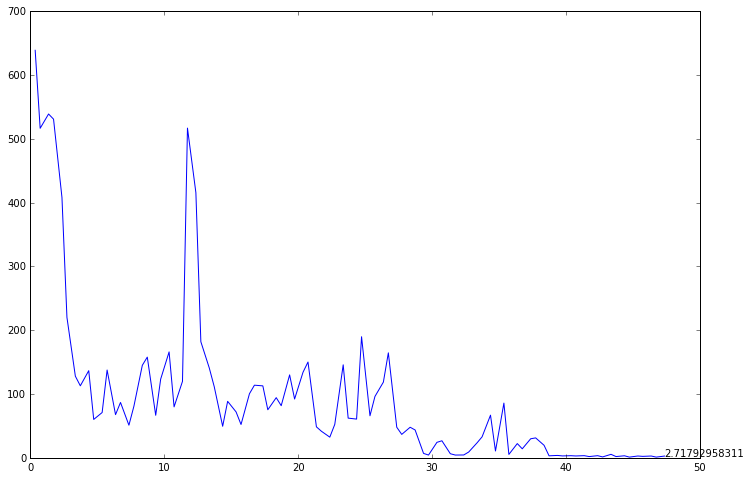

'done'

In [8]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

epochs = []
losses = []

show_period = 40
while not done:
    if pos == 0:
        state = net.newState() # create new clear state
    
    (grad, loss) = learn(net, state, pos, seq_len)
            
    grad.clip(5e0)
    rate.update(grad)
    net.learn(grad, rate)
    
    smooth_loss = 0.9*smooth_loss + 0.1*loss
    
    if (seq+1) % show_period == 0:
        smooth_epoch = epoch + pos/len(data)
        epochs.append(smooth_epoch)
        losses.append(smooth_loss)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(epochs, losses)
        ax.text(smooth_epoch,smooth_loss,str(smooth_loss))
        
        display.clear_output(wait=True)

        plt.show()
        
    pos += seq_len*size
    seq += 1
    
    if pos + size > len(data):
        pos = 0
        seq = 0
        epoch += 1
    
'done'

Generate sound from current position and state:

''

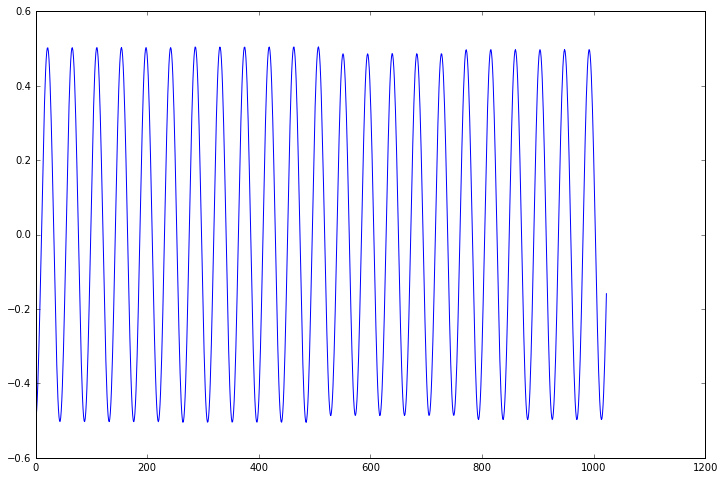

In [9]:
vin = data[pos:pos+size]
sst = copy(state)
gen = np.array(0)

for i in range(1024):
    vins = [vin]
    vouts = np.real(net.transmit(sst, vins))
    tvout = np.tanh(vouts[0])
    gen = np.append(gen, tvout)
    vin = tvout

wavfile.write('out.wav', br, gen)
plt.plot(gen[:1024])
''